# Usage (quick version)

## Preparation

In [1]:
# Standard users
# !pip install covsirphy
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [2]:
import warnings

In [3]:
import covsirphy as cs
cs.__version__

'2.8.3-beta.new.224.fix.248'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/



Detailed citaition list:
Open Government Data, United Kingdom (2020), https://coronavirus.data.gov.uk
Department of Disease Control of Thailand (2020), https://covid19.th-stat.com/
World Health Organization (2020), https://covid19.who.int
Ireland Health Protection Surveillance Centre (HPSC) and Health Service Executive (HSE) (2020), https://covid19ireland-geohive.hub.arcgis.com/
The COVID Tracking Project (2020), https://covidtracking.com
Ministry of Health of Croatia (2020), https://data.gov.hr/dataset/koronavirus/resource/08fab529-ebba-46c7-be79-05782ddb02ef
Open Government Data, Latvia (2020), https://data.gov.lv/dati/dataset
Taiwan Ministry of Health and Welfare (2020), https://data.gov.tw/dataset/120451
Wikipedia (2020), https://en.wikipedia.org/wiki
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be
Johns Hopkins Center for Systems Science and Engineering (2020), https://github.com/CSSEGISandData/COVID-19
Covid19data.com.au (2020), https://github.com/M3IT/

### The number of cases (JHU style)

In [5]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation


In [6]:
print(data_loader.covid19dh_citation)

Open Government Data, United Kingdom (2020), https://coronavirus.data.gov.uk
Department of Disease Control of Thailand (2020), https://covid19.th-stat.com/
World Health Organization (2020), https://covid19.who.int
Ireland Health Protection Surveillance Centre (HPSC) and Health Service Executive (HSE) (2020), https://covid19ireland-geohive.hub.arcgis.com/
The COVID Tracking Project (2020), https://covidtracking.com
Ministry of Health of Croatia (2020), https://data.gov.hr/dataset/koronavirus/resource/08fab529-ebba-46c7-be79-05782ddb02ef
Open Government Data, Latvia (2020), https://data.gov.lv/dati/dataset
Taiwan Ministry of Health and Welfare (2020), https://data.gov.tw/dataset/120451
Wikipedia (2020), https://en.wikipedia.org/wiki
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be
Johns Hopkins Center for Systems Science and Engineering (2020), https://github.com/CSSEGISandData/COVID-19
Covid19data.com.au (2020), https://github.com/M3IT/COVID-19_Data
Data Science

In [7]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
277676,2020-10-15,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
277677,2020-10-16,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
277678,2020-10-17,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
277679,2020-10-18,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
277680,2020-10-19,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3


In [8]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
277676,2020-10-15,Colombia,Vichada,14,0,0,14
277677,2020-10-16,Colombia,Vichada,14,0,0,14
277678,2020-10-17,Colombia,Vichada,14,0,0,14
277679,2020-10-18,Colombia,Vichada,14,0,0,14
277680,2020-10-19,Colombia,Vichada,14,0,0,14


In [9]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
210,2020-10-15,28420,2147,427,25846
211,2020-10-16,28604,2082,431,26091
212,2020-10-17,28839,2099,434,26306
213,2020-10-18,28971,2061,436,26474
214,2020-10-19,29049,2036,436,26577


In [10]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-10-15,38510920,10961390,1089969,26459561,0.014151,0.343533,0.039564
2020-10-16,38912461,11171147,1095968,26645346,0.014082,0.342375,0.039507
2020-10-17,39273308,11339017,1101344,26832947,0.014022,0.341618,0.039426
2020-10-18,39565355,11443732,1104505,27017118,0.013958,0.341424,0.039276
2020-10-19,39565743,11442873,1104508,27018362,0.013958,0.341436,0.039274


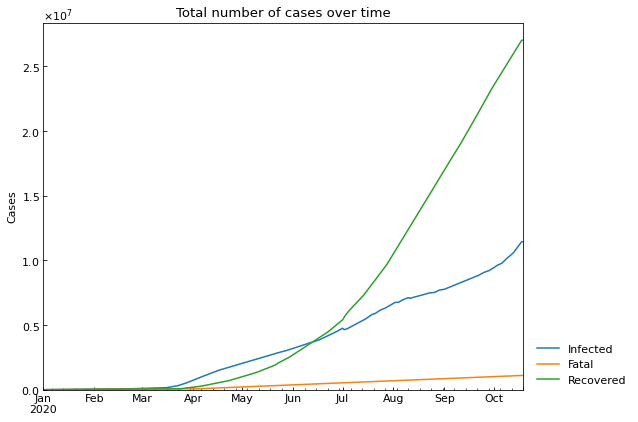

In [11]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan


In [12]:
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
249,2020-10-15,91416,5951,1649,83816
250,2020-10-16,92057,5964,1664,84429
251,2020-10-17,92681,5999,1670,85012
252,2020-10-18,93112,5972,1674,85466
253,2020-10-19,93422,5845,1676,85901


In [13]:
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan


In [14]:
jhu_data.replace(japan_data)
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
247,2020-10-15,90710,5227,1646,83837
248,2020-10-16,91431,5330,1650,84451
249,2020-10-17,92063,5372,1661,85030
250,2020-10-18,92656,5501,1670,85485
251,2020-10-19,93127,5512,1674,85941


### Population in each country

In [15]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation


In [16]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
277676,2020-10-15,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
277677,2020-10-16,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
277678,2020-10-17,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
277679,2020-10-18,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
277680,2020-10-19,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3


In [17]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Date,Population
235658,COL,Colombia,Vichada,2020-10-15,107808
235659,COL,Colombia,Vichada,2020-10-16,107808
235660,COL,Colombia,Vichada,2020-10-17,107808
235661,COL,Colombia,Vichada,2020-10-18,107808
235662,COL,Colombia,Vichada,2020-10-19,107808


In [18]:
population_data.value("Japan", province=None)

126529100

In [19]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)

In [20]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation


In [21]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
277676,2020-10-15,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
277677,2020-10-16,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
277678,2020-10-17,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
277679,2020-10-18,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3
277680,2020-10-19,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,1,1,4,2,2,0,71.3


In [22]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
277676,2020-10-15,Colombia,COL,3,1,2,3,1,1,1,4,2,2,0,71.3
277677,2020-10-16,Colombia,COL,3,1,2,3,1,1,1,4,2,2,0,71.3
277678,2020-10-17,Colombia,COL,3,1,2,3,1,1,1,4,2,2,0,71.3
277679,2020-10-18,Colombia,COL,3,1,2,3,1,1,1,4,2,2,0,71.3
277680,2020-10-19,Colombia,COL,3,1,2,3,1,1,1,4,2,2,0,71.3


In [23]:
# Subset for a country
oxcgrt_data.subset("Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
288,2020-10-15,1,1,1,0,0,1,1,1,2,2,1,31.48
289,2020-10-16,1,1,1,0,0,1,1,1,2,2,1,31.48
290,2020-10-17,1,1,1,0,0,1,1,1,2,2,1,31.48
291,2020-10-18,1,1,1,0,0,1,1,1,2,2,1,31.48
292,2020-10-19,1,1,1,0,0,1,1,1,2,2,1,31.48


In [24]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset("JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
288,2020-10-15,1,1,1,0,0,1,1,1,2,2,1,31.48
289,2020-10-16,1,1,1,0,0,1,1,1,2,2,1,31.48
290,2020-10-17,1,1,1,0,0,1,1,1,2,2,1,31.48
291,2020-10-18,1,1,1,0,0,1,1,1,2,2,1,31.48
292,2020-10-19,1,1,1,0,0,1,1,1,2,2,1,31.48


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [25]:
scenario = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records

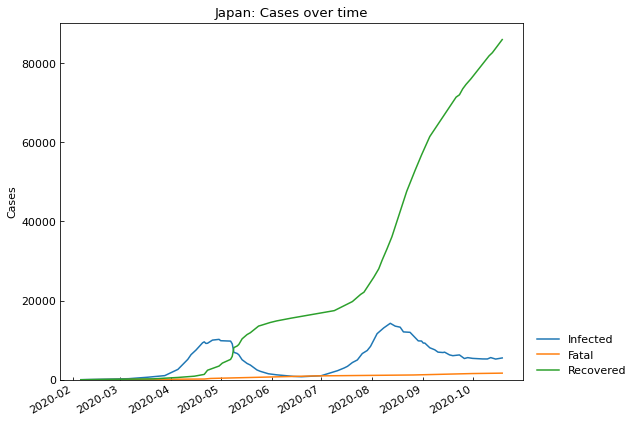

,Date,Confirmed,Infected,Fatal,Recovered
247,2020-10-15,90710,5227,1646,83837
248,2020-10-16,91431,5330,1650,84451
249,2020-10-17,92063,5372,1661,85030
250,2020-10-18,92656,5501,1670,85485
251,2020-10-19,93127,5512,1674,85941


In [26]:
import matplotlib
warnings.simplefilter("ignore", category=matplotlib.MatplotlibDeprecationWarning)
record_df = scenario.records()
record_df.tail()

### S-R trend analysis

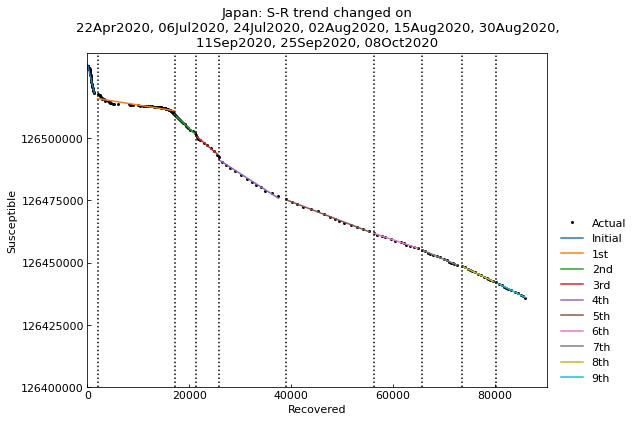

,Type,Start,End,Population
0th,Past,06Feb2020,21Apr2020,126529100
1st,Past,22Apr2020,05Jul2020,126529100
2nd,Past,06Jul2020,23Jul2020,126529100
3rd,Past,24Jul2020,01Aug2020,126529100
4th,Past,02Aug2020,14Aug2020,126529100
5th,Past,15Aug2020,29Aug2020,126529100
6th,Past,30Aug2020,10Sep2020,126529100
7th,Past,11Sep2020,24Sep2020,126529100
8th,Past,25Sep2020,07Oct2020,126529100
9th,Past,08Oct2020,19Oct2020,126529100


In [27]:
scenario.trend(set_phases=True)
scenario.summary()

### Hyperparameter estimation of ODE models
As an example, use SIR-F model.
We can use SIR, SIRD, (SIRFV), (SEWIRF).

In [28]:
scenario.estimate(cs.SIRF)


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	9th phase (08Oct2020 - 19Oct2020): finished  289 trials in 0 min 10 sec


	3rd phase (24Jul2020 - 01Aug2020): finished 1423 trials in 0 min 50 sec

	1st phase (22Apr2020 - 05Jul2020): finished 1500 trials in 1 min  0 sec

	0th phase (06Feb2020 - 21Apr2020): finished 1530 trials in 1 min  0 sec

	2nd phase (06Jul2020 - 23Jul2020): finished 1545 trials in 1 min  0 sec

	7th phase (11Sep2020 - 24Sep2020): finished  163 trials in 0 min  5 sec

	5th phase (15Aug2020 - 29Aug2020): finished  332 trials in 0 min 10 sec

	6th phase (30Aug2020 - 10Sep2020): finished  515 trials in 0 min 15 sec

	4th phase (02Aug2020 - 14Aug2020): finished 1643 trials in 1 min  0 sec

	8th phase (25Sep2020 - 07Oct2020): finished 1744 trials in 1 min  0 sec

Completed optimization. Total: 2 min 16 sec


In [29]:
scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/gamma [day],1/beta [day],alpha1 [-],1/alpha2 [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,21Apr2020,126529100,SIR-F,4.88,0.000120,0.000594,0.025352,0.004603,360,54,9,0.000,420,0.929576,1530,1 min 0 sec
1st,Past,22Apr2020,05Jul2020,126529100,SIR-F,0.35,0.024362,0.000674,0.005654,0.015186,360,16,44,0.024,370,0.856353,1500,1 min 0 sec
2nd,Past,06Jul2020,23Jul2020,126529100,SIR-F,2.05,0.001082,0.000026,0.032676,0.015885,360,15,7,0.001,9569,0.032069,1545,1 min 0 sec
3rd,Past,24Jul2020,01Aug2020,126529100,SIR-F,1.90,0.000629,0.000072,0.032966,0.017232,360,14,7,0.001,3487,0.020294,1423,0 min 50 sec
4th,Past,02Aug2020,14Aug2020,126529100,SIR-F,1.34,0.000822,0.000085,0.024402,0.018074,360,13,10,0.001,2951,0.096278,1643,1 min 0 sec
5th,Past,15Aug2020,29Aug2020,126529100,SIR-F,0.82,0.000634,0.000235,0.020920,0.025186,360,9,11,0.001,1065,0.026549,332,0 min 10 sec
6th,Past,30Aug2020,10Sep2020,126529100,SIR-F,0.68,0.019551,0.000090,0.016388,0.023605,360,10,15,0.020,2770,0.013449,515,0 min 15 sec
7th,Past,11Sep2020,24Sep2020,126529100,SIR-F,0.92,0.003232,0.000309,0.022383,0.024019,360,10,11,0.003,808,0.028490,163,0 min 5 sec
8th,Past,25Sep2020,07Oct2020,126529100,SIR-F,0.98,0.000121,0.000293,0.023966,0.024259,360,10,10,0.000,852,0.012229,1744,1 min 0 sec
9th,Past,08Oct2020,19Oct2020,126529100,SIR-F,1.09,0.003616,0.000082,0.024059,0.021969,360,11,10,0.004,3046,0.020704,289,0 min 10 sec


### Accuracy of estimation

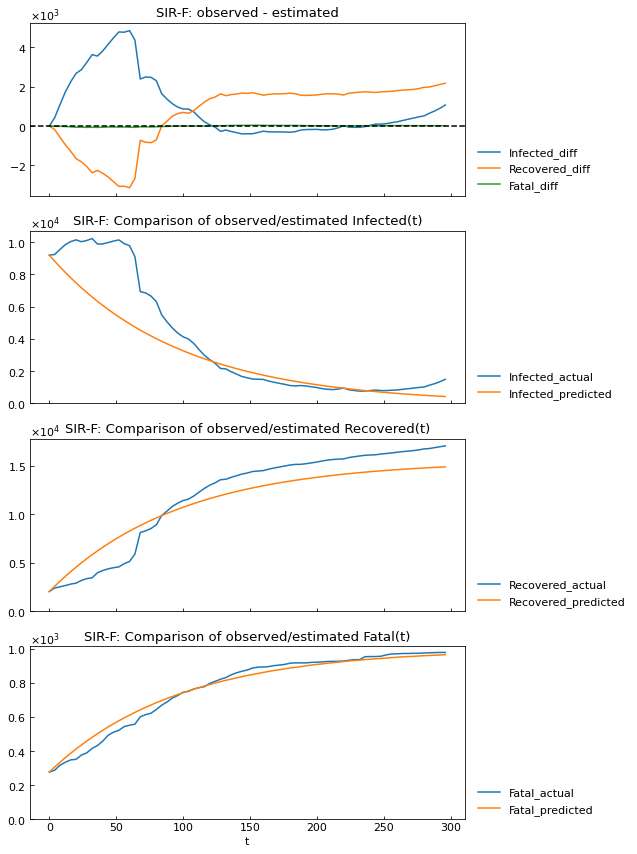

In [30]:
scenario.estimate_accuracy(phase="1st")

### Get parameter value

In [31]:
scenario.get("Rt", phase="4th")

1.34

### Show parameter history

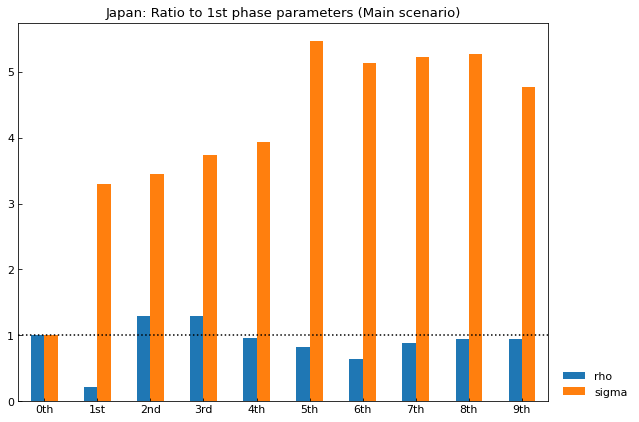

,0th,1st,2nd,3rd,4th,5th,6th,7th,8th,9th
rho,1.0,0.223028,1.288870,1.300302,0.962524,0.825156,0.646403,0.882859,0.945326,0.948992
sigma,1.0,3.299309,3.451361,3.743972,3.926901,5.472097,5.128554,5.218538,5.270695,4.773227


In [32]:
df = scenario.param_history(targets=["rho", "sigma"])
df.T

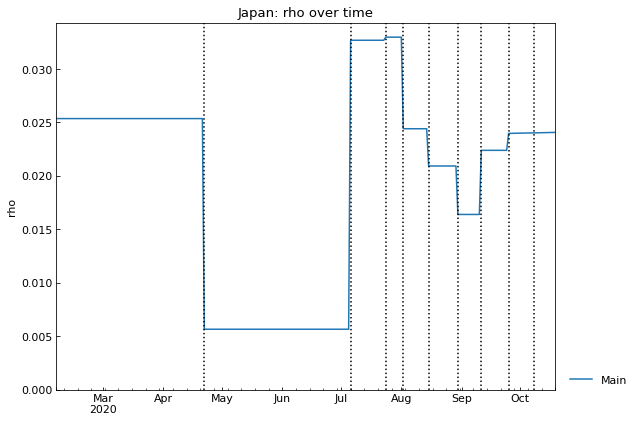

In [33]:
_ = scenario.history(target="rho")

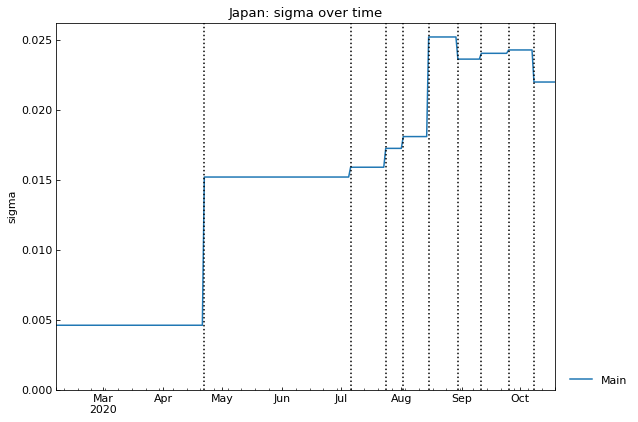

In [34]:
_ = scenario.history(target="sigma")

### Show the history of reproduction number

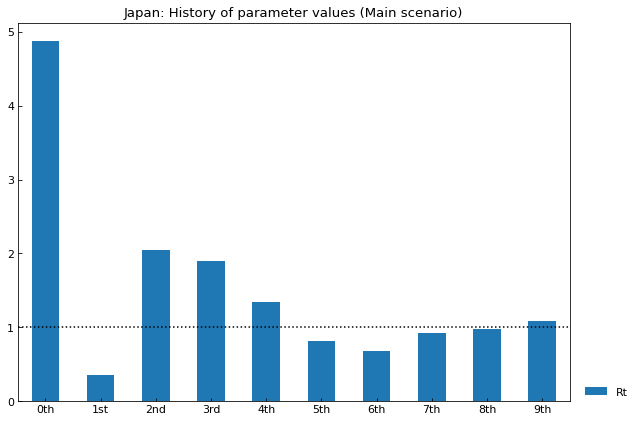

,0th,1st,2nd,3rd,4th,5th,6th,7th,8th,9th
Rt,4.88,0.35,2.05,1.9,1.34,0.82,0.68,0.92,0.98,1.09


In [35]:
df = scenario.param_history(targets=["Rt"], divide_by_first=False, show_box_plot=True)
df.T

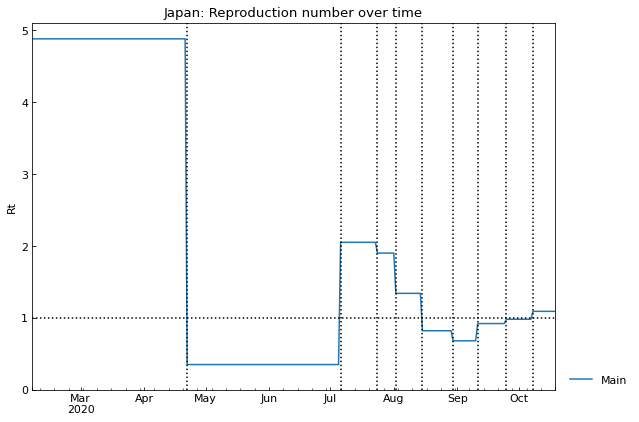

In [36]:
_ = scenario.history(target="Rt")

### Simulate the number of cases

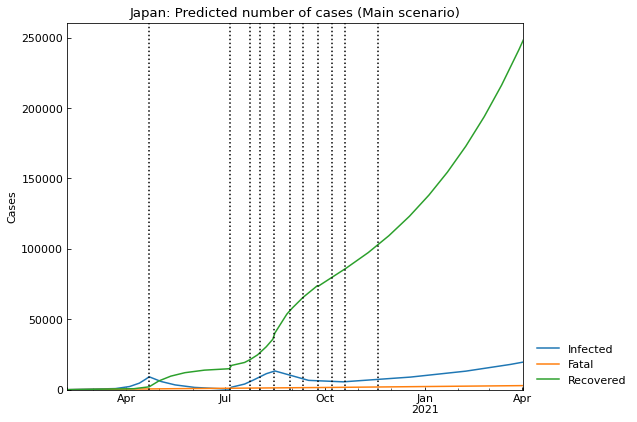

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,263289,2852,19028,241409
418,2021-03-30,265123,2865,19171,243087
419,2021-03-31,266971,2878,19315,244778
420,2021-04-01,268833,2891,19460,246482
421,2021-04-02,270708,2904,19606,248198


In [37]:
scenario.clear(name="Main")
scenario.add(days=30)
scenario.add(end_date="01Apr2021", name="Main")
main_sim_df = scenario.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [38]:
sigma_current = scenario.get("sigma", name="Main", phase="last")
sigma_current

0.021969445916949704

In [39]:
sigma_new = sigma_current * 2
sigma_new

0.04393889183389941

In [40]:
scenario.clear(name="Medicine")
scenario.add(name="Medicine", days=30, sigma=sigma_current)
scenario.add(name="Medicine", end_date="01Apr2021", sigma=sigma_new)
scenario.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario Phase                                                          
Main     0th      Past  06Feb2020  21Apr2020   126529100  SIR-F  4.88   
         1st      Past  22Apr2020  05Jul2020   126529100  SIR-F  0.35   
         2nd      Past  06Jul2020  23Jul2020   126529100  SIR-F  2.05   
         3rd      Past  24Jul2020  01Aug2020   126529100  SIR-F  1.90   
         4th      Past  02Aug2020  14Aug2020   126529100  SIR-F  1.34   
         5th      Past  15Aug2020  29Aug2020   126529100  SIR-F  0.82   
         6th      Past  30Aug2020  10Sep2020   126529100  SIR-F  0.68   
         7th      Past  11Sep2020  24Sep2020   126529100  SIR-F  0.92   
         8th      Past  25Sep2020  07Oct2020   126529100  SIR-F  0.98   
         9th      Past  08Oct2020  19Oct2020   126529100  SIR-F  1.09   
         10th   Future  20Oct2020  18Nov2020   126529100  SIR-F  1.09   
         11th   Future  19Nov2020  01Apr2021   126529100  SIR-F  1.09   
Medicine 0th      Past  06Feb2020  21Apr2020   126529100  SIR-F  4.88   
         1st      Past  22Apr2020  05Jul2020   126529100  SIR-F  0.35   
         2nd      Past  06Jul2020  23Jul2020   126529100  SIR-F  2.05   
         3rd      Past  24Jul2020  01Aug2020   126529100  SIR-F  1.90   
         4th      Past  02Aug2020  14Aug2020   126529100  SIR-F  1.34   
         5th      Past  15Aug2020  29Aug2020   126529100  SIR-F  0.82   
         6th      Past  30Aug2020  10Sep2020   126529100  SIR-F  0.68   
         7th      Past  11Sep2020  24Sep2020   126529100  SIR-F  0.92   
         8th      Past  25Sep2020  07Oct2020   126529100  SIR-F  0.98   
         9th      Past  08Oct2020  19Oct2020   126529100  SIR-F  1.09   
         10th   Future  20Oct2020  18Nov2020   126529100  SIR-F  1.09   
         11th   Future  19Nov2020  01Apr2021   126529100  SIR-F  0.54   

                   theta     kappa       rho     sigma  tau  1/gamma [day]  \
Scenario Phase                                                               
Main     0th    0.000120  0.000594  0.025352  0.004603  360             54   
         1st    0.024362  0.000674  0.005654  0.015186  360             16   
         2nd    0.001082  0.000026  0.032676  0.015885  360             15   
         3rd    0.000629  0.000072  0.032966  0.017232  360             14   
         4th    0.000822  0.000085  0.024402  0.018074  360             13   
         5th    0.000634  0.000235  0.020920  0.025186  360              9   
         6th    0.019551  0.000090  0.016388  0.023605  360             10   
         7th    0.003232  0.000309  0.022383  0.024019  360             10   
         8th    0.000121  0.000293  0.023966  0.024259  360             10   
         9th    0.003616  0.000082  0.024059  0.021969  360             11   
         10th   0.003616  0.000082  0.024059  0.021969  360             11   
         11th   0.003616  0.000082  0.024059  0.021969  360             11   
Medicine 0th    0.000120  0.000594  0.025352  0.004603  360             54   
         1st    0.024362  0.000674  0.005654  0.015186  360             16   
         2nd    0.001082  0.000026  0.032676  0.015885  360             15   
         3rd    0.000629  0.000072  0.032966  0.017232  360             14   
         4th    0.000822  0.000085  0.024402  0.018074  360             13   
         5th    0.000634  0.000235  0.020920  0.025186  360              9   
         6th    0.019551  0.000090  0.016388  0.023605  360             10   
         7th    0.003232  0.000309  0.022383  0.024019  360             10   
         8th    0.000121  0.000293  0.023966  0.024259  360             10   
         9th    0.003616  0.000082  0.024059  0.021969  360             11   
         10th   0.003616  0.000082  0.024059  0.021969  360             11   
         11th   0.003616  0.000082  0.024059  0.043939  360              5   

                1/beta [day]  alpha1 [-]  1/alpha2 [day]      RMSLE Trials  \
Scenario Pha

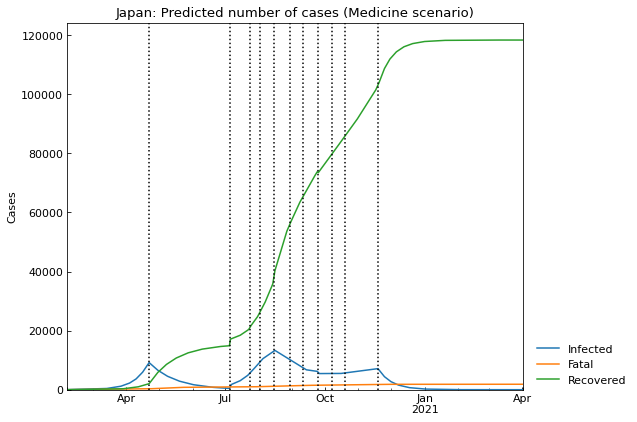

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,120213,1846,0,118367
418,2021-03-30,120213,1846,0,118367
419,2021-03-31,120213,1846,0,118367
420,2021-04-01,120213,1846,0,118367
421,2021-04-02,120213,1846,0,118367


In [41]:
scenario.simulate(name="Medicine").tail()

### Compare the scenarios

In [42]:
scenario.describe()

,max(Infected),argmax(Infected),Infected on 02Apr2021,Fatal on 02Apr2021,11th_Rt
Main,19606,02Apr2021,19606,2904,1.09
Medicine,13547,15Aug2020,0,1846,0.54


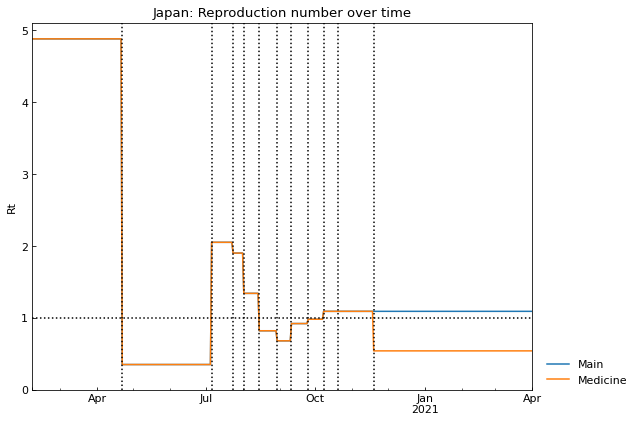

In [43]:
_ = scenario.history(target="Rt")

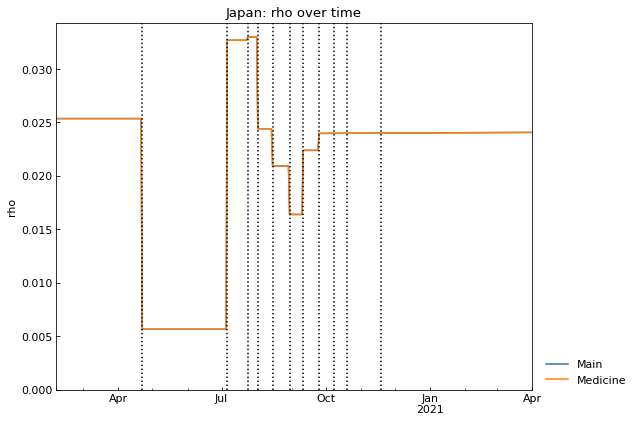

In [44]:
_ = scenario.history(target="rho")

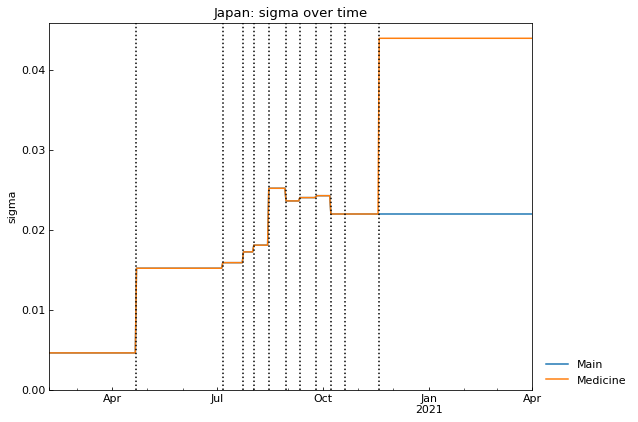

In [45]:
_ = scenario.history(target="sigma")

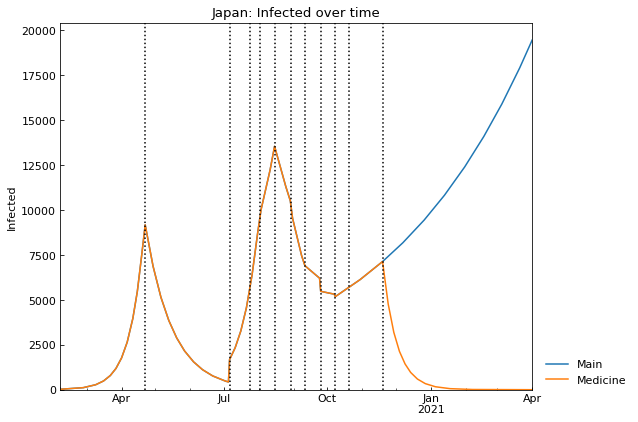

In [46]:
_ = scenario.history(target="Infected")

### Change rate of parameters in main scenario

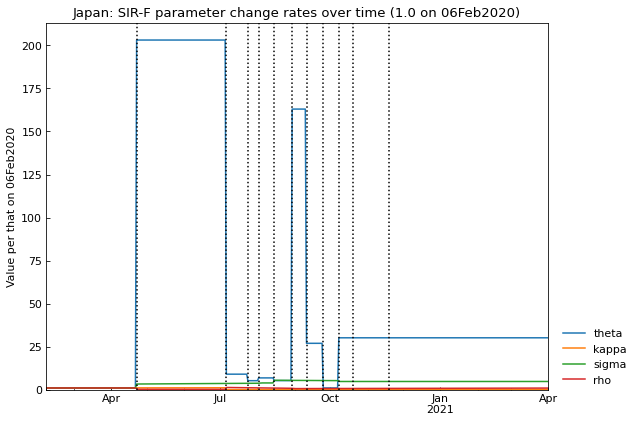

In [47]:
# >= 2.8.3-alpha.new.224 (will be included in 2.9.0)
_ = scenario.history_rate(name="Main")